In [1]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error

In [2]:
import mlflow
MLFLOW_TACKING_URI = "sqlite:////home/youseef/mlflow.db"
mlflow.set_tracking_uri(MLFLOW_TACKING_URI)
mlflow.set_experiment('nyc-experiment')

2025/07/17 02:12:45 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/07/17 02:12:45 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


<Experiment: artifact_location='/home/youseef/MLOps-zoomcamp/02-experimental-tracking/mlruns/4', creation_time=1752706239795, experiment_id='4', last_update_time=1752706239795, lifecycle_stage='active', name='nyc-experiment', tags={}>

In [3]:
df = pd.read_parquet('/home/youseef/MLOps-zoomcamp/data/green_tripdata_2023-01.parquet')
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [4]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

7.0590084265576

/tmp/ipykernel_12296/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_12296/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


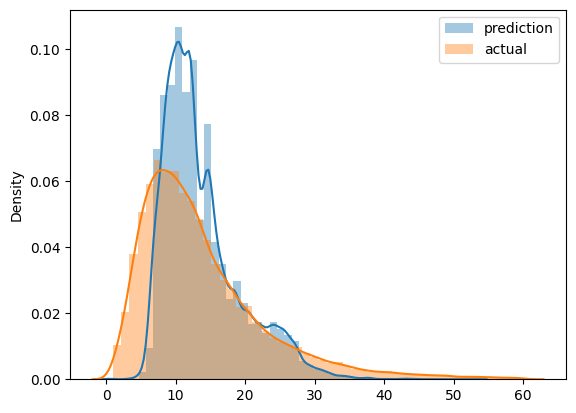

In [5]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [6]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [7]:
df_train = read_dataframe('/home/youseef/MLOps-zoomcamp/data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('/home/youseef/MLOps-zoomcamp/data/green_tripdata_2021-02.parquet')

In [8]:
len(df_train), len(df_val)

(73908, 61921)

In [9]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [10]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [11]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [12]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.758715205807849

In [13]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [14]:
with mlflow.start_run():
    alpha = 0.01
    mlflow.set_tag("developer", 'YoussefMoamen')
    mlflow.log_param('train-data-path', '/home/youseef/MLOps-zoomcamp/data/green_tripdata_2021-01')
    mlflow.log_param('valid-data-path', '/home/youseef/MLOps-zoomcamp/data/green_tripdata_2021-02')
    mlflow.log_param('alpha', alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse  = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric('rmse', rmse)

In [15]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [16]:
mlflow.xgboost.autolog()
train = xgb.DMatrix(data=X_train, label=y_train)
valid = xgb.DMatrix(data=X_val, label=y_val)

In [17]:
def objective(params):
    with mlflow.start_run(nested=True):
        mlflow.set_tag('model', 'xgboost')
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=100,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric('rmse', rmse)
    return {'loss': rmse, 'status': STATUS_OK}

In [18]:
search_space = {
    'max_depth' : scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha' : hp.loguniform('reg_alpha', -5, -1),
    'min_child_weight' : hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed' : 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=5,
    trials=Trials()   
)


  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

/home/youseef/anaconda/envs/attention/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [02:12:52] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:9.51985                          
[1]	validation-rmse:8.06113                          
[2]	validation-rmse:7.31185                          
[3]	validation-rmse:6.93232                          
[4]	validation-rmse:6.73797                          
[5]	validation-rmse:6.63525                          
[6]	validation-rmse:6.57565                          
[7]	validation-rmse:6.53862                          
[8]	validation-rmse:6.51574                          
[9]	validation-rmse:6.49816                          
[10]	validation-rmse:6.48672                         
[11]	validation-rmse:6.47862                         
[12]	validation-rmse:6.47120                         
[13]	validation-rmse:6.46636                         
[14]	validation-rmse:6.46294                         
[15]	validation-rmse:6.45924                         
[16]	validation-rmse:6.45520                         
[17]	validation-rmse:6.45199                         
[18]	validation-rmse:6.45047

2025/07/17 02:13:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/17 02:13:07 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/youseef/anaconda/envs/attention/lib/python3.10/site-packages/mlflow/xgboost/__init__.py:168: UserWarning: [02:13:07] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."



 20%|██        | 1/5 [00:37<02:29, 37.27s/trial, best loss: 6.351314923952441]

/home/youseef/anaconda/envs/attention/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [02:13:29] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.28028                                                  
[1]	validation-rmse:10.48959                                                  
[2]	validation-rmse:9.82276                                                   
[3]	validation-rmse:9.26365                                                   
[4]	validation-rmse:8.79631                                                   
[5]	validation-rmse:8.40822                                                   
[6]	validation-rmse:8.08732                                                   
[7]	validation-rmse:7.82334                                                   
[8]	validation-rmse:7.60604                                                   
[9]	validation-rmse:7.42776                                                   
[10]	validation-rmse:7.28129                                                  
[11]	validation-rmse:7.16186                                                  
[12]	validation-rmse:7.06296                        

2025/07/17 02:13:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/17 02:13:51 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/youseef/anaconda/envs/attention/lib/python3.10/site-packages/mlflow/xgboost/__init__.py:168: UserWarning: [02:13:51] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."



 40%|████      | 2/5 [01:12<01:48, 36.29s/trial, best loss: 6.351314923952441]

/home/youseef/anaconda/envs/attention/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [02:14:04] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.07337                                                  
[1]	validation-rmse:10.14164                                                  
[2]	validation-rmse:9.38475                                                   
[3]	validation-rmse:8.77831                                                   
[4]	validation-rmse:8.29424                                                   
[5]	validation-rmse:7.91174                                                   
[6]	validation-rmse:7.60849                                                   
[7]	validation-rmse:7.37077                                                   
[8]	validation-rmse:7.18454                                                   
[9]	validation-rmse:7.03980                                                   
[10]	validation-rmse:6.92467                                                  
[11]	validation-rmse:6.83553                                                  
[12]	validation-rmse:6.76356                        

2025/07/17 02:14:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/17 02:14:33 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/youseef/anaconda/envs/attention/lib/python3.10/site-packages/mlflow/xgboost/__init__.py:168: UserWarning: [02:14:33] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."



 60%|██████    | 3/5 [02:04<01:27, 43.51s/trial, best loss: 6.351314923952441]

/home/youseef/anaconda/envs/attention/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [02:14:58] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:7.69118                                                   
[1]	validation-rmse:6.84194                                                   
[2]	validation-rmse:6.66568                                                   
[3]	validation-rmse:6.62039                                                   
[4]	validation-rmse:6.60009                                                   
[5]	validation-rmse:6.59061                                                   
[6]	validation-rmse:6.58300                                                   
[7]	validation-rmse:6.57432                                                   
[8]	validation-rmse:6.56712                                                   
[9]	validation-rmse:6.56200                                                   
[10]	validation-rmse:6.55528                                                  
[11]	validation-rmse:6.55105                                                  
[12]	validation-rmse:6.54751                        

2025/07/17 02:15:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/17 02:15:09 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/youseef/anaconda/envs/attention/lib/python3.10/site-packages/mlflow/xgboost/__init__.py:168: UserWarning: [02:15:09] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."



[0]	validation-rmse:9.84211                                                   
 80%|████████  | 4/5 [02:41<00:39, 39.41s/trial, best loss: 6.351314923952441]

/home/youseef/anaconda/envs/attention/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [02:15:30] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:8.45466                                                   
[2]	validation-rmse:7.67691                                                   
[3]	validation-rmse:7.24822                                                   
[4]	validation-rmse:7.01658                                                   
[5]	validation-rmse:6.88821                                                   
[6]	validation-rmse:6.81068                                                   
[7]	validation-rmse:6.76534                                                   
[8]	validation-rmse:6.73393                                                   
[9]	validation-rmse:6.71566                                                   
[10]	validation-rmse:6.70096                                                  
[11]	validation-rmse:6.68654                                                  
[12]	validation-rmse:6.67745                                                  
[13]	validation-rmse:6.67050                        

2025/07/17 02:15:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/17 02:15:47 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/youseef/anaconda/envs/attention/lib/python3.10/site-packages/mlflow/xgboost/__init__.py:168: UserWarning: [02:15:47] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."



100%|██████████| 5/5 [03:05<00:00, 37.04s/trial, best loss: 6.351314923952441]


In [19]:
from mlflow.tracking import MlflowClient
from mlflow.entities import ViewType

client = MlflowClient()

# Include all experiments (ACTIVE and DELETED)
experiments = client.search_experiments(view_type=ViewType.ACTIVE_ONLY)


In [20]:

for exp in experiments:
    print(f"Name: {exp.name}, ID: {exp.experiment_id}, Lifecycle: {exp.lifecycle_stage}")


Name: nyc-experiment, ID: 4, Lifecycle: active
Name: Default, ID: 0, Lifecycle: active


In [21]:
runs = client.search_runs(
    experiment_ids='4',
    filter_string="",
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=5,
    order_by=['metrics.rmse']
)

In [22]:
for run in runs:
    print(f"run_id : {run.info.run_id} rmse: {run.data.metrics['rmse']}")

run_id : 9b50dc5d54534913b4e7bea39dd7d763 rmse: 6.351314923952441
run_id : ecfb50b672714519801011b402ea977c rmse: 6.374437734292755
run_id : f4cec4af01614a0c947474309657a0b1 rmse: 6.416482285878589
run_id : af2251031eea41e081165fdddea9fb83 rmse: 6.486915838842628
run_id : b508482c978f4e6b80306df135ef7524 rmse: 6.632326037619017


In [25]:
run_id = runs[-1].info.run_id # The best model


model_uri = f'runs:/{run_id}/model'
mlflow.register_model(model_uri=model_uri, name='taxi-best')

Registered model 'taxi-best' already exists. Creating a new version of this model...
2025/07/17 02:46:43 WARNING mlflow.tracking._model_registry.fluent: Run with id b508482c978f4e6b80306df135ef7524 has no artifacts at artifact path 'model', registering model based on models:/m-15676a5831cd4034905df268acab17d0 instead
Created version '6' of model 'taxi-best'.


<ModelVersion: aliases=[], creation_timestamp=1752709603623, current_stage='None', deployment_job_state=None, description=None, last_updated_timestamp=1752709603623, metrics=None, model_id=None, name='taxi-best', params=None, run_id='b508482c978f4e6b80306df135ef7524', run_link=None, source='models:/m-15676a5831cd4034905df268acab17d0', status='READY', status_message=None, tags={}, user_id=None, version=6>